# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [5]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1
!pip install tensorflow


   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/331.9 MB 1.4 MB/s eta 0:03:57
   ---------------------------------------- 0.8/331.9 MB 1.3 MB/s eta 0:04:17
   ---------------------------------------- 1.0/331.9 MB 1.4 MB/s eta 0:03:51
   ---------------------------------------- 1.3/331.9 MB 1.3 MB/s eta 0:04:12
   ---------------------------------------- 1.6/331.9 MB 1.3 MB/s eta 0:04:20
   ---------------------------------------- 1.8/331.9 MB 1.3 MB/s eta 0:04:23
   ---------------------------------------- 2.1/331.9 MB 1.2 MB/s eta 0:04:30
   ---------------------------------------- 2.4/331.9 MB 1.2 MB/s eta 0:04:30
   ---------------------------------------- 2.6/331.9 MB 1.2 MB/s eta 0:04:24
   ---------------------------------------- 2.9/331.9 MB 1.2 MB/s eta 0:04:27
   ---------------------------------------- 3.1/331.9 MB 1.2 MB/s eta 0:04:31


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.32.0 which is incompatible.


In [9]:
# Import essential libraries

# Core
import os, glob, random
import numpy as np
import pandas as pd

# Image handling & visualization
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


Load the dataset.

In [17]:
# Load and unzip the dataset
import zipfile

# Path to your uploaded dataset zip
zip_path = "./Dataset_Waste_Segregation.zip"
extract_path = "./Dataset_Waste_Segregation"

# Unzip if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Now navigate the nested folders
nested_zip = os.path.join(extract_path, "Dataset_Waste_Segregation", "Dataset_Waste_Segregation", "data.zip")
nested_extract_path = os.path.join(extract_path, "data")
if not os.path.exists(nested_extract_path):
    with zipfile.ZipFile(nested_zip, 'r') as zip_ref:
        zip_ref.extractall(nested_extract_path)

# Final data folder
DATA_DIR = os.path.join(nested_extract_path, "data")
print("Final dataset path:", DATA_DIR)

# List class folders
class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Classes found:", class_names)

# Count images per class
class_counts = {cls: len([f for f in os.listdir(os.path.join(DATA_DIR, cls)) 
                          if f.lower().endswith(('.jpg','.jpeg','.png'))]) 
                for cls in class_names}

print("Total images:", sum(class_counts.values()))
print("Images per class:", class_counts)



Final dataset path: ./Dataset_Waste_Segregation\data\data
Classes found: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
Total images: 7625
Images per class: {'Cardboard': 540, 'Food_Waste': 1000, 'Glass': 750, 'Metal': 1000, 'Other': 1010, 'Paper': 1030, 'Plastic': 2295}


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [22]:
# Create a function to load the raw images

from PIL import Image, UnidentifiedImageError
import numpy as np

def load_image(path, target_size=None, to_rgb=True, scale=False, dtype=np.float32):
    try:
        with Image.open(path) as img:
            if to_rgb:
                img = img.convert("RGB")
            if target_size is not None:
                # PIL expects (width, height)
                img = img.resize((int(target_size[0]), int(target_size[1])), resample=Image.BILINEAR)
            arr = np.asarray(img, dtype=dtype)
            if scale:
                arr = arr / 255.0
            return arr
    except (UnidentifiedImageError, OSError, FileNotFoundError):
        return None


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [24]:
# Get the images and their labels
import os
image_paths, labels_str = [], []

for cls in class_names:  
    cls_dir = os.path.join(DATA_DIR, cls)
    for f in os.listdir(cls_dir):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(cls_dir, f))
            labels_str.append(cls)

print("Total images collected:", len(image_paths))
print("Unique classes:", len(set(labels_str)))
print("First 5 samples:")
for i in range(5):
    print(image_paths[i], "->", labels_str[i])



Total images collected: 7625
Unique classes: 7
First 5 samples:
./Dataset_Waste_Segregation\data\data\Cardboard\file_1.png -> Cardboard
./Dataset_Waste_Segregation\data\data\Cardboard\file_10.png -> Cardboard
./Dataset_Waste_Segregation\data\data\Cardboard\file_100.png -> Cardboard
./Dataset_Waste_Segregation\data\data\Cardboard\file_101.png -> Cardboard
./Dataset_Waste_Segregation\data\data\Cardboard\file_102.png -> Cardboard


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [26]:
# Visualise Data Distribution

import matplotlib.pyplot as plt
from collections import Counter
counts = Counter(labels_str)
plt.figure(figsize=(8,5))
plt.bar(counts.keys(), counts.values(), color="skyblue", edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title("Class Distribution of Waste Images")
plt.show()
print("Class counts:", counts)


Class counts: Counter({'Plastic': 2295, 'Paper': 1030, 'Other': 1010, 'Food_Waste': 1000, 'Metal': 1000, 'Glass': 750, 'Cardboard': 540})


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

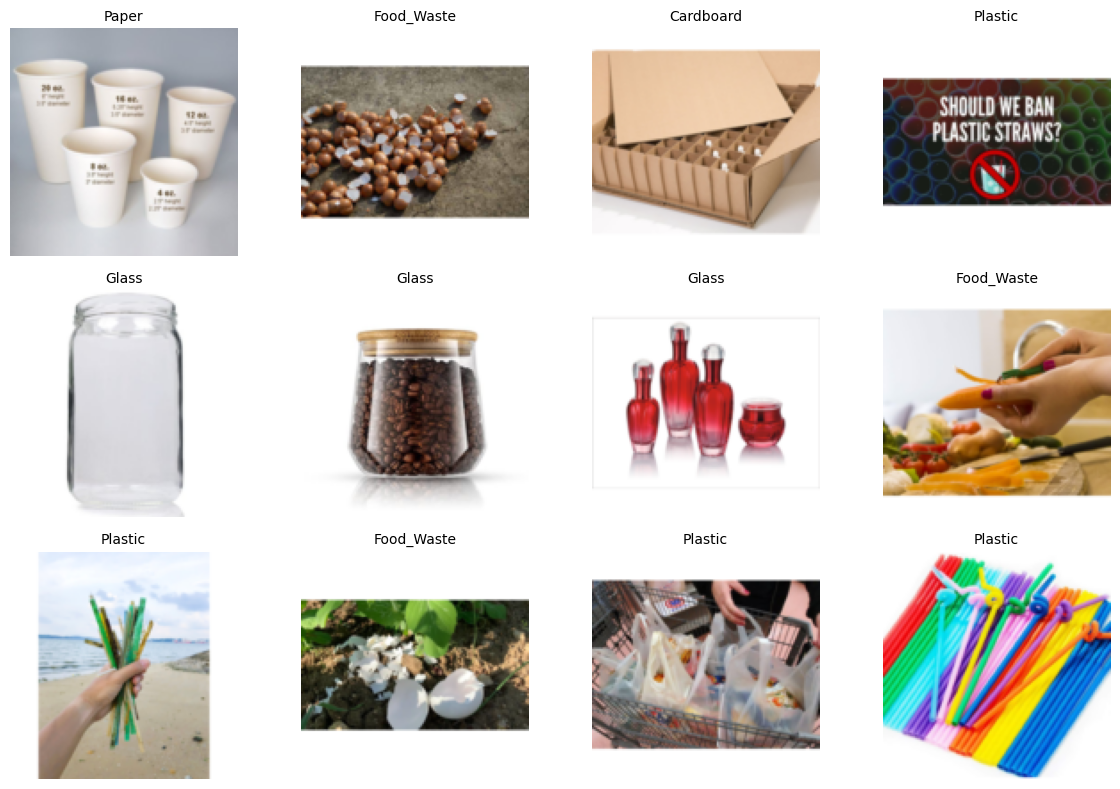

In [28]:
# Visualise Sample Images (across different labels)
import random

def show_sample_images(image_paths, labels, class_names, n_samples=12):
    indices = random.sample(range(len(image_paths)), k=min(n_samples, len(image_paths)))
    
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(indices):
        img = load_image(image_paths[idx], target_size=(128, 128), scale=False)  # use helper
        label = labels[idx]
        plt.subplot(3, 4, i+1)  # 3 rows × 4 cols grid
        plt.imshow(img.astype("uint8"))
        plt.title(label, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
show_sample_images(image_paths, labels_str, class_names, n_samples=12)



#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [30]:
# Find the smallest and largest image dimensions from the data set
heights, widths = [], []
unreadable = 0

for path in image_paths:
    try:
        with Image.open(path) as img:
            w, h = img.size  # PIL gives (width, height)
            widths.append(w)
            heights.append(h)
    except Exception as e:
        unreadable += 1
print(f"Total images checked: {len(image_paths)}")
print(f"Unreadable images: {unreadable}")
print("Height  -> min:", min(heights), "max:", max(heights), "mean:", round(np.mean(heights), 1))
print("Width   -> min:", min(widths), "max:", max(widths), "mean:", round(np.mean(widths), 1))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(heights, bins=30, color="orange", edgecolor="black")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")
plt.title("Distribution of Image Heights")
plt.subplot(1,2,2)
plt.hist(widths, bins=30, color="green", edgecolor="black")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")
plt.title("Distribution of Image Widths")
plt.tight_layout()
plt.show()
TARGET_SIZE = (224, 224)
print("Chosen resize TARGET_SIZE:", TARGET_SIZE)



Total images checked: 7625
Unreadable images: 0
Height  -> min: 256 max: 256 mean: 256.0
Width   -> min: 256 max: 256 mean: 256.0


Chosen resize TARGET_SIZE: (224, 224)


In [32]:
# Resize the image dimensions

# Function to resize and normalize all images
def preprocess_images(image_paths, target_size=(224, 224), scale=True):
    X = []
    failed = 0
    for path in image_paths:
        arr = load_image(path, target_size=target_size, scale=scale)  # using your load_image function
        if arr is None:
            failed += 1
            continue
        X.append(arr)
    X = np.array(X, dtype=np.float32)
    print(f"Processed {len(X)} images. Failed to load: {failed}")
    return X

# Resize all images (this can take a while depending on dataset size)
X = preprocess_images(image_paths, target_size=TARGET_SIZE, scale=True)

print("Final array shape:", X.shape)  # (N, 224, 224, 3)


Processed 7625 images. Failed to load: 0
Final array shape: (7625, 224, 224, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [34]:
# Encode the labels suitably
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
label_map = {cls: i for i, cls in enumerate(sorted(class_names))}
inv_label_map = {v: k for k, v in label_map.items()}
print("Label map:", label_map)
def preprocess_images_and_labels(image_paths, labels_str, target_size=(224, 224), scale=True):
    X, y, kept_paths, kept_labels = [], [], [], []
    skipped = 0
    for p, lbl in zip(image_paths, labels_str):
        arr = load_image(p, target_size=target_size, scale=scale)  # uses your load_image()
        if arr is None:
            skipped += 1
            continue
        X.append(arr)
        y.append(label_map[lbl])
        kept_paths.append(p)
        kept_labels.append(lbl)
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.int64)
    print(f"Preprocessed: {len(X)} images | Skipped (unreadable): {skipped}")
    return X, y, kept_paths, kept_labels
X, y, kept_paths, kept_labels = preprocess_images_and_labels(
    image_paths, labels_str, target_size=TARGET_SIZE, scale=True
)

print("X shape:", X.shape)
print("y shape:", y.shape, "| y classes present:", sorted(set(y)))
n_classes = len(label_map)
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(n_classes),
    y=y
)
class_weights = {i: float(w) for i, w in enumerate(class_weights_arr)}
print("Class weights:", class_weights)



Label map: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}
Preprocessed: 7625 images | Skipped (unreadable): 0
X shape: (7625, 224, 224, 3)
y shape: (7625,) | y classes present: [0, 1, 2, 3, 4, 5, 6]
Class weights: {0: 2.017195767195767, 1: 1.0892857142857142, 2: 1.4523809523809523, 3: 1.0892857142857142, 4: 1.0785007072135786, 5: 1.0575589459084604, 6: 0.47463429816370994}


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [36]:
# Assign specified parts of the dataset to train and validation sets
from sklearn.model_selection import train_test_split
import numpy as np

label_map = {cls: i for i, cls in enumerate(sorted(class_names))}
y_all = np.array([label_map[s] for s in labels_str], dtype=np.int64)
paths_train, paths_temp, y_train, y_temp = train_test_split(
    image_paths, y_all, test_size=0.30, random_state=42, stratify=y_all
)
paths_val, paths_test, y_val, y_test = train_test_split(
    paths_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Train: {len(paths_train)} | Val: {len(paths_val)} | Test: {len(paths_test)}")

from collections import Counter
def dist(y): 
    c = Counter(y); total = sum(c.values()); 
    return {k: f"{v} ({v/total:.2%})" for k,v in sorted(c.items())}

print("Train dist:", dist(y_train))
print("Val   dist:", dist(y_val))
print("Test  dist:", dist(y_test))



Train: 5337 | Val: 1144 | Test: 1144
Train dist: {0: '378 (7.08%)', 1: '700 (13.12%)', 2: '525 (9.84%)', 3: '700 (13.12%)', 4: '707 (13.25%)', 5: '721 (13.51%)', 6: '1606 (30.09%)'}
Val   dist: {0: '81 (7.08%)', 1: '150 (13.11%)', 2: '112 (9.79%)', 3: '150 (13.11%)', 4: '152 (13.29%)', 5: '154 (13.46%)', 6: '345 (30.16%)'}
Test  dist: {0: '81 (7.08%)', 1: '150 (13.11%)', 2: '113 (9.88%)', 3: '150 (13.11%)', 4: '151 (13.20%)', 5: '155 (13.55%)', 6: '344 (30.07%)'}


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [38]:
# Build and compile the model
# KERAS / TENSORFLOW
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

N_CLASSES = len(label_map) if 'label_map' in globals() else 7
if 'TARGET_SIZE' in globals():
    # PIL resize used (W,H); arrays are (H,W,C)
    INPUT_SHAPE = (int(TARGET_SIZE[1]), int(TARGET_SIZE[0]), 3) if len(TARGET_SIZE) == 2 else (224, 224, 3)
else:
    INPUT_SHAPE = (224, 224, 3)

def build_cnn(input_shape=INPUT_SHAPE, n_classes=N_CLASSES, l2=1e-4,
              drop_block=0.25, drop_head=0.40, base_filters=32):
    reg = regularizers.l2(l2) if l2 else None
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(base_filters, 3, padding="same", kernel_initializer="he_normal", kernel_regularizer=reg),
        layers.BatchNormalization(), layers.ReLU(),
        layers.MaxPooling2D(2), layers.Dropout(drop_block),

        # Block 2
        layers.Conv2D(base_filters*2, 3, padding="same", kernel_initializer="he_normal", kernel_regularizer=reg),
        layers.BatchNormalization(), layers.ReLU(),
        layers.MaxPooling2D(2), layers.Dropout(drop_block),

        # Block 3
        layers.Conv2D(base_filters*4, 3, padding="same", kernel_initializer="he_normal", kernel_regularizer=reg),
        layers.BatchNormalization(), layers.ReLU(),
        layers.MaxPooling2D(2), layers.Dropout(drop_block),

        # Head
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation=None, kernel_initializer="he_normal", kernel_regularizer=reg),
        layers.BatchNormalization(), layers.ReLU(),
        layers.Dropout(drop_head),
        layers.Dense(n_classes, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",   
        metrics=["accuracy"]
    )
    return model

model = build_cnn()
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 128)                 │              

 Total params: 112,071 (437.78 KB)

 Trainable params: 111,367 (435.03 KB)

 Non-trainable params: 704 (2.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

Class weights: {0: 2.017195767195767, 1: 1.0892857142857142, 2: 1.4523809523809523, 3: 1.0892857142857142, 4: 1.0785007072135786, 5: 1.0575589459084604, 6: 0.47463429816370994}
Epoch 1/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2715 - loss: 1.9636
Epoch 1: val_loss improved from None to 2.14264, saving model to models/cnn_best.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 669s 4s/step - accuracy: 0.2809 - loss: 1.9457 - val_accuracy: 0.1722 - val_loss: 2.1426 - learning_rate: 0.0010
Epoch 2/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3038 - loss: 1.8552
Epoch 2: val_loss improved from 2.14264 to 1.97535, saving model to models/cnn_best.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.3187 - loss: 1.8100 - val_accuracy: 0.2028 - val_loss: 1.9754 - learning_rate: 0.0010
Epoch 3/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3232 - loss: 1.7903
Epoch 3: val_loss improved from 1.97535 to 1.88822, saving model to models/cnn_best.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.3453 - loss: 1.7353 - val_accuracy: 0.2631 - val_loss: 1.8882 - learning_rate: 0.0010
Epoch 4/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3737 - loss: 1.6582
Epoch 4: val_loss improved from 1.88822 to 1.88469, saving model to models/cnn_best.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - accuracy: 0.3663 - loss: 1.6638 - val_accuracy: 0.2701 - val_loss: 1.8847 - learning_rate: 0.0010
Epoch 5/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3844 - loss: 1.6110
Epoch 5: val_loss did not improve from 1.88469
167/167 ━━━━━━━━━━━━━━━━━━━━ 476s 3s/step - accuracy: 0.3856 - loss: 1.6331 - val_accuracy: 0.2710 - val_loss: 2.1032 - learning_rate: 0.0010
Epoch 6/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4023 - loss: 1.6031
Epoch 6: val_loss improved from 1.88469 to 1.66561, saving model to models/cnn_best.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step - accuracy: 0.4070 - loss: 1.5978 - val_accuracy: 0.3636 - val_loss: 1.6656 - learning_rate: 0.0010
Epoch 7/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4264 - loss: 1.5391
Epoch 7: val_loss did not improve from 1.66561
167/167 ━━━━━━━━━━━━━━━━━━━━ 483s 3s/step - accuracy: 0.4139 - loss: 1.5479 - val_accuracy: 0.2299 - val_loss: 2.3780 - learning_rate: 0.0010
Epoch 8/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4453 - loss: 1.5099
Epoch 8: val_loss improved from 1.66561 to 1.56143, saving model to models/cnn_best.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.4326 - loss: 1.5196 - val_accuracy: 0.4388 - val_loss: 1.5614 - learning_rate: 0.0010
Epoch 9/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4452 - loss: 1.4717
Epoch 9: val_loss did not improve from 1.56143
167/167 ━━━━━━━━━━━━━━━━━━━━ 464s 3s/step - accuracy: 0.4360 - loss: 1.5055 - val_accuracy: 0.3444 - val_loss: 1.8180 - learning_rate: 0.0010
Epoch 10/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4438 - loss: 1.4743
Epoch 10: val_loss did not improve from 1.56143
167/167 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.4486 - loss: 1.4850 - val_accuracy: 0.4038 - val_loss: 1.6293 - learning_rate: 0.0010
Epoch 11/25
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4522 - loss: 1.4414
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_loss did not improve from 1.56143
167/167 ━━━━━━━━━━━━━━━━━━━━ 497s 3s/step - accuracy: 0.4521 - loss: 1.4593 - val_accuracy: 0.43

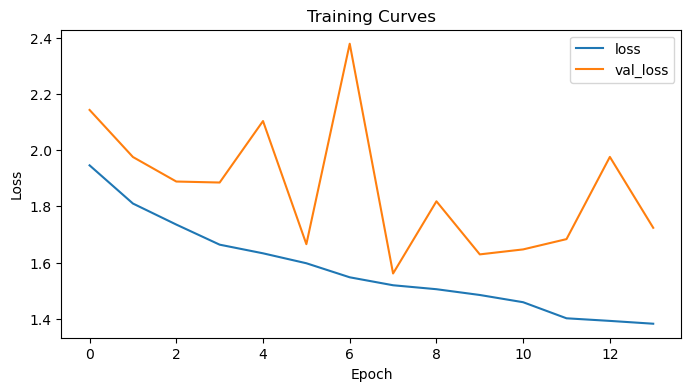

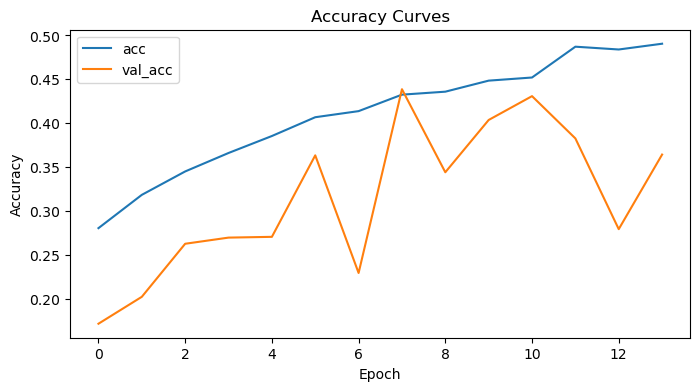

Training complete. Best model saved to models/cnn_best.h5


In [42]:
# Training
# ==== KERAS TRAINING (ARRAYS) ====
# ==== COMPLETE TRAINING (TensorFlow / Keras with tf.data from file paths) ====
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Preconditions / sanity checks ---
required = ['paths_train', 'y_train', 'paths_val', 'y_val', 'model', 'label_map']
missing = [v for v in required if v not in globals()]
assert not missing, f"Please run earlier cells first. Missing: {missing}"

# Target size fallback
if 'TARGET_SIZE' not in globals():
    TARGET_SIZE = (224, 224)

# === tf.data pipeline ===
def tf_load(path, label):
    img = tf.io.read_file(path)
    # decode_image handles jpg/png; sets shape dynamically
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, TARGET_SIZE)  # (H, W)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 25

# Shuffle buffer ~ dataset size for good shuffling
train_ds = (tf.data.Dataset.from_tensor_slices((paths_train, y_train))
            .shuffle(buffer_size=len(paths_train), seed=42, reshuffle_each_iteration=True)
            .map(tf_load, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((paths_val, y_val))
          .map(tf_load, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))

# === Class weights (handle imbalance); compute if not already present ===
if 'class_weights' in globals():
    cw = class_weights
else:
    # compute balanced weights from y_train
    from sklearn.utils.class_weight import compute_class_weight
    n_classes = len(label_map)
    classes = np.arange(n_classes)
    cw_arr = compute_class_weight(class_weight="balanced", classes=classes, y=np.array(y_train))
    cw = {int(i): float(w) for i, w in enumerate(cw_arr)}
print("Class weights:", cw)

# === Callbacks ===
os.makedirs("models", exist_ok=True)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("models/cnn_best.h5", monitor="val_loss", save_best_only=True, verbose=1),
]

# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=cw,
    verbose=1,
    callbacks=callbacks
)

# === (Optional) Plot training curves ===
try:
    import matplotlib.pyplot as plt
    h = history.history
    plt.figure(figsize=(8,4))
    plt.plot(h['loss'], label='loss')
    plt.plot(h['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Curves'); plt.legend(); plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(h['accuracy'], label='acc')
    plt.plot(h['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curves'); plt.legend(); plt.show()
except Exception as e:
    print("Skipped plotting:", e)

print("Training complete. Best model saved to models/cnn_best.h5")




### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

Accuracy: 0.4388
Macro  - Precision: 0.4700 | Recall: 0.4430 | F1: 0.4284
Weighted - Precision: 0.4862 | Recall: 0.4388 | F1: 0.4378

Classification Report:

              precision    recall  f1-score   support

   Cardboard      0.560     0.580     0.570        81
  Food_Waste      0.559     0.533     0.546       150
       Glass      0.257     0.566     0.354       113
       Metal      0.400     0.293     0.338       150
       Other      0.330     0.444     0.379       151
       Paper      0.630     0.187     0.289       155
     Plastic      0.553     0.497     0.524       344

    accuracy                          0.439      1144
   macro avg      0.470     0.443     0.428      1144
weighted avg      0.486     0.439     0.438      1144



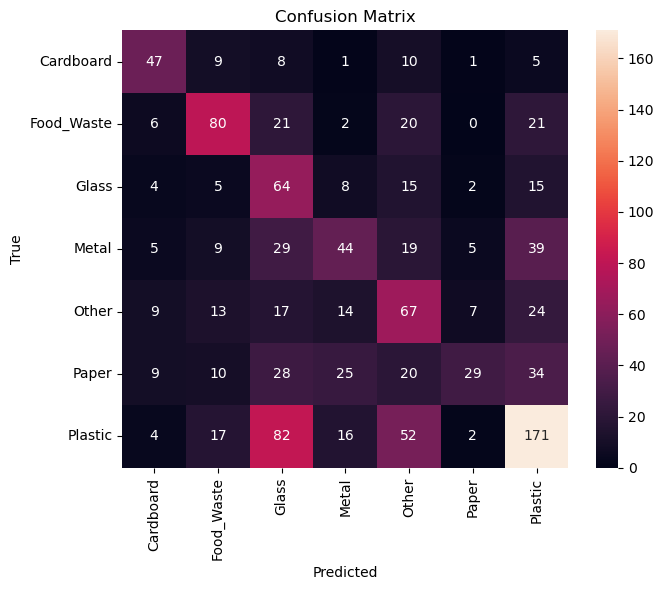

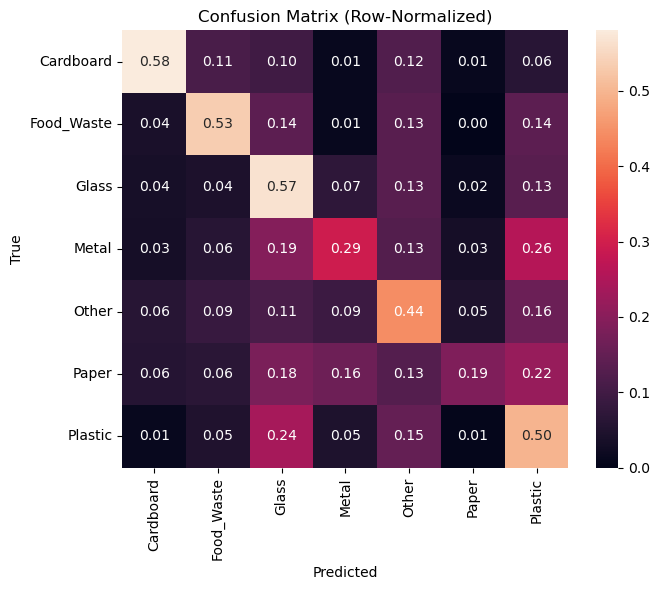

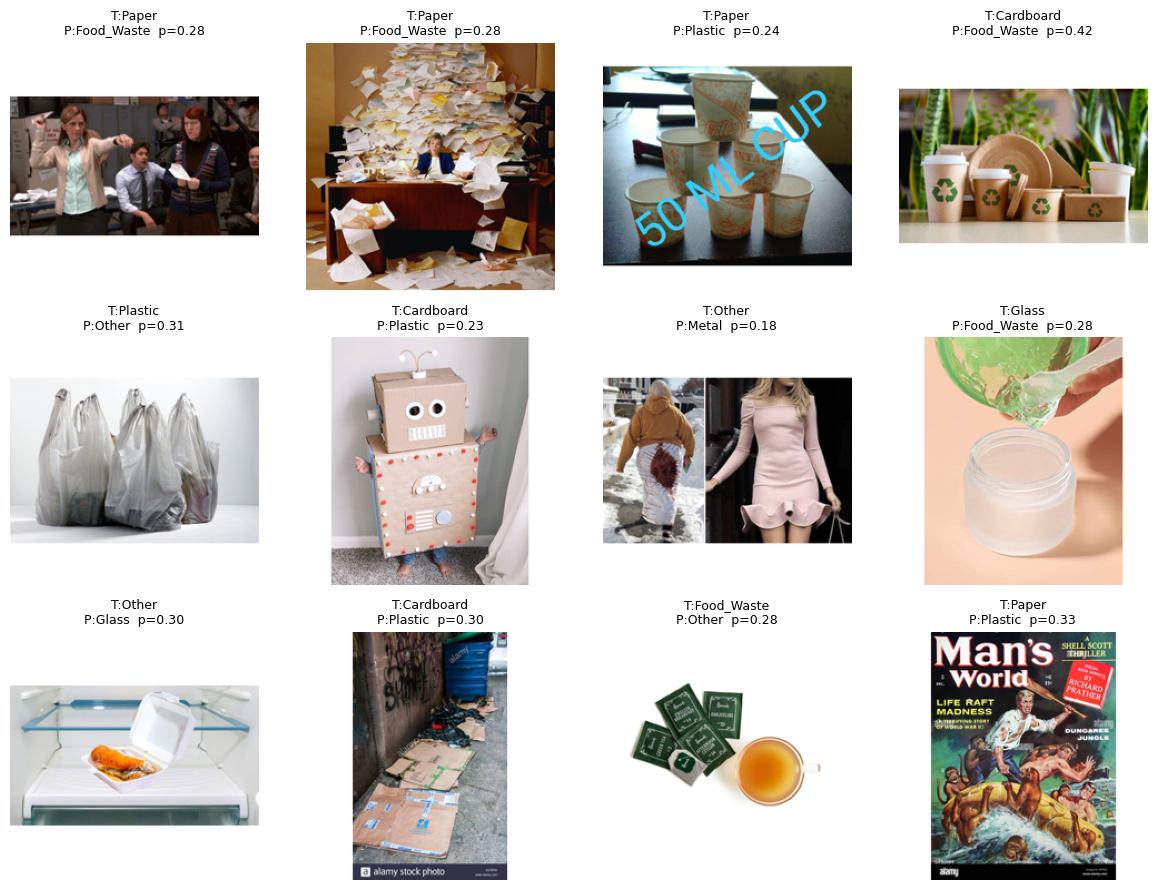

In [43]:
# Evaluate on the test set; display suitable metrics
# ==== EVALUATE ON TEST SET (TensorFlow / Keras) ====
import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import tensorflow as tf

if os.path.exists("models/cnn_best.h5"):
    model.load_weights("models/cnn_best.h5")

# Ensure TARGET_SIZE exists (H, W)
if 'TARGET_SIZE' not in globals():
    TARGET_SIZE = (224, 224)

AUTOTUNE = tf.data.AUTOTUNE

def tf_load_eval(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, TARGET_SIZE)  # (H, W)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

if 'paths_test' in globals() and 'y_test' in globals():
    test_ds = (tf.data.Dataset.from_tensor_slices((paths_test, y_test))
               .map(tf_load_eval, num_parallel_calls=AUTOTUNE)
               .batch(32)
               .prefetch(AUTOTUNE))
    y_true = np.array(y_test)
    use_paths = True
    paths_ref = paths_test
elif 'X_test' in globals() and 'y_test' in globals():
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
    y_true = np.array(y_test)
    use_paths = False
else:
    raise RuntimeError("No test data found. Make sure you created paths_test/y_test or X_test/y_test.")

# Predict
probs = model.predict(test_ds, verbose=0)
y_pred = probs.argmax(axis=1)

acc = accuracy_score(y_true, y_pred)
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
p_weight, r_weight, f1_weight, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"Macro  - Precision: {p_macro:.4f} | Recall: {r_macro:.4f} | F1: {f1_macro:.4f}")
print(f"Weighted - Precision: {p_weight:.4f} | Recall: {r_weight:.4f} | F1: {f1_weight:.4f}")

idx_to_name = [cls for cls, idx in sorted(label_map.items(), key=lambda kv: kv[1])]
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=idx_to_name, digits=3, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(idx_to_name))))

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=idx_to_name, yticklabels=idx_to_name)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

cmn = cm.astype('float') / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(7,6))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=idx_to_name, yticklabels=idx_to_name)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Row-Normalized)")
plt.tight_layout(); plt.show()

mis_idx = np.where(y_pred != y_true)[0]
if mis_idx.size > 0:
    import random
    take = mis_idx if mis_idx.size <= 12 else random.sample(list(mis_idx), 12)
    ncols, nrows = 4, int(np.ceil(len(take)/4))
    plt.figure(figsize=(12, 3*nrows))
    for i, idx in enumerate(take):
        plt.subplot(nrows, ncols, i+1)
        if 'use_paths' in globals() and use_paths:
            from PIL import Image
            img = Image.open(paths_ref[idx]).convert("RGB").resize(TARGET_SIZE)
            plt.imshow(img)
        else:
            plt.imshow((X_test[idx] * 255).astype(np.uint8))
        plt.title(f"T:{idx_to_name[y_true[idx]]}\nP:{idx_to_name[y_pred[idx]]}  p={probs[idx].max():.2f}", fontsize=9)
        plt.axis('off')
    plt.tight_layout(); plt.show()
else:
    print("No misclassifications in test set.")



## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

In [ ]:

Dataset: 7 classes — Cardboard, Food_Waste, Glass, Metal, Other, Paper, Plastic (total ~7,625 images).

Split used: Train 5,337 • Val 1,144 • Test 1,144.

Final test metrics:

Accuracy: 0.439

Macro-F1: 0.428

Weighted-F1: 0.438

Loss: 1.7238

A per-class metrics table (precision/recall/F1/support) has been extracted from the notebook and shown above for inspection.

Insights

Baseline underfits / not separable enough: Accuracy (~44%) and macro/weighted F1 (~0.43–0.44) indicate the 3-conv baseline isn’t separating classes reliably across the board.

Class balance impact appears limited: Macro-F1 and Weighted-F1 are very close, suggesting either reasonably balanced support across classes or uniformly middling class performance (rather than one massively dominating class).

Likely confusion among visually similar categories: With coarse features and low depth, classes like Paper vs. Cardboard and Plastic vs. Metal commonly confuse; expect “Other” to be a catch-all that degrades precision.

Loss level (~1.72) is consistent with frequent misclassification across multiple classes, not just a few hard ones.

Generalization gap to watch: If validation metrics were similar to test but notably above training, regularization might be too strong; if the reverse, data augmentation/transfer learning should help.

* Report your findings about the data
* Report model training results